<a href="https://colab.research.google.com/github/rodelafue/Simulacion-UDEC/blob/master/Activity%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating an Activity Network using Simpy and Networkx

Firts, you need to install [simpy](https://simpy.readthedocs.io/en/latest/) and [networkx](https://networkx.github.io/)

In [1]:
!pip install simpy
!pip install networkx

 Now, these are the basic libraries we will need for the model

In [2]:
import random 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk',style='whitegrid',font='serif')
import simpy
import networkx as nx


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 Out of the required libraries, I want to highlight the use of networkx which we will use
to build the project's network. Besides, it will allow us to keep track of all predecessor activities.
 Now, we have to create several classes to build the activity network.

In [3]:
class ActivityProcess(object):
    """
    ActivityProcess "This class controls the execution of each process. Firts, based on precedence
    it will evaluate that all the required predecessor events are finalized. Next, the particular
    activity will be executed (timed-out); and then, the activity is marked as completed"

    :param object: the root object
    :type object: object
    """
    def __init__(self, env, name):
        """
        __init__ This is the class's constructor that sets up the process governing each activity

        :param env: A simpy environment
        :type env: Simpy object
        :param name: The name of the activity
        :type name: string
        """
        self.env = env
        self.name = name
        
    def waitup(self,node, myEvent, verbose = False):
        """
        waitup This method keeps track of the project completion at the node level, activating the
        proper timeouts depending on the relative completion of the preceding activities

        :param node: A reference to the position of this node into the network
        :type node: int
        :param myEvent: A specific event to be excetuted in the aforementioned position
        :type myEvent: CustomEvent
        """
        # PEM illustrating "waitevent"# wait for "myEvent" to occur
        evnt = [e.event for e in myEvent]
        yield self.env.all_of(evnt)
        if verbose:
            print("The activating event(s) were %s" %([x.name for x in myEvent]))
        tis = random.expovariate(1.0)
        yield self.env.timeout(tis)
        finishtime = self.env.now
        if finishtime > SANglobal.finishtime:
            SANglobal.finishtime = finishtime
        SANglobal.F.nodecomplete[node].event.succeed()

class StartSignaller(object):
    """
    StartSignaller This class is required to start the simulation

    :param object: the root object
    :type object: object
    :yield: The device used by simpy to hold on an activity
    :rtype: boolan (succeed)
    """
    # here we just schedule some events to fire
    def __init__(self, env, name,sEvent):
        """
        __init__ The constructor of the class

        :param env: A simpy environment
        :type env: Simpy object
        :param name: The name of the activity
        :type name: string
        :param sEvent: A custom event that belongs to the environment
        :type sEvent: CustomEvent
        """
        self.env = env
        self.name = name
        self.sEvent = sEvent
        self.env.process(self.startSignals())
        
    def startSignals(self):
        """
        startSignals A method that start the simulation, having zero yield time and marking 
        this initial event as succeeeded

        :yield: A zero timeout
        :rtype: boolean
        """
        yield self.env.timeout(0)
        self.sEvent.event.succeed()

class CustomEvent(object):
    """
    CustomEvent to represent an specific event that belongs to environment. In our case, it 
    corresponds to an activity that have to be carried out during the project

    :param object: The root object
    :type object: object
    """
    def __init__(self, env, name):
        """
        __init__ the constructor of the class

        :param env: a Simpy environment
        :type env: Simpy object
        :param name: The name of the event
        :type name: string
        """
        self.name = name
        self.env = env
        self.event = self.env.event()        
        
class SANglobal:
    """
     This class is used to hold global variables
    """
    F = nx.DiGraph() # A directed graph
    a = 0
    b = 1
    c = 2
    d = 3
    inTo = 0
    F.add_nodes_from([a, b, c, d]) # add activities to networkx
    F.add_edges_from([(a,b), (a,c), (b,c), (b,d), (c,d)]) # activities' connections
    finishtime = 0 # counter for the finishing time



 Now, we are ready to evaluate our project. To do so, we will run 1000 realizations to study its stochasticity.

In [4]:
finishtimes = []
for rep in range(1000):
    SANglobal.finishtime = 0 # Global collector for finish time
    env = simpy.Environment() # Create simulation environment
    SANglobal.F.nodecomplete= [] # set an empty list for nodes
    for i in range(len(SANglobal.F.nodes())): # Iterate through the nodes
        eventname = 'Complete%1d' % i
        SANglobal.F.nodecomplete.append(CustomEvent(env,eventname)) # Add custom events to be triggered

    activitynode = [] # set of activities 
    for i in range(len(SANglobal.F.nodes())): 
        activityname = 'Activity%1d' % i # add a name for the activity
        activitynode.append(ActivityProcess(env,activityname)) # Include the activity on a list
        
    for i in range(len(SANglobal.F.nodes())):
        if i is not SANglobal.inTo:
            prenodes = SANglobal.F.predecessors(i) # Save the predecessor nodes to node i
            preevents = [SANglobal.F.nodecomplete[j] for j in prenodes] # Select the preevents
            env.process(activitynode[i].waitup(i,preevents)) # Activate the waitup for the specific event
            
    startevent = CustomEvent(env,'Start') # Create a start event
    sstart = StartSignaller(env,'Signal',startevent).startSignals() # set the event flag to succeed 
    env.process(activitynode[SANglobal.inTo].waitup(SANglobal.inTo, [startevent]))  
    
    env.run(until=50)
    finishtimes.append(SANglobal.finishtime) # Append the project's completion time


 Finally, we are going to plot the results.

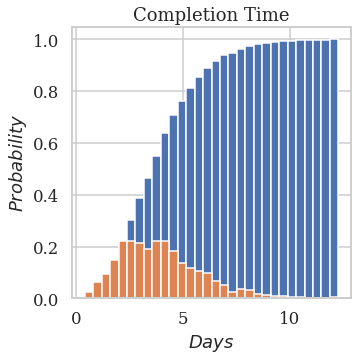

In [7]:
plt.figure(figsize=(5,5))
plt.hist(finishtimes, bins = 30, density = True, cumulative=True)  
plt.hist(finishtimes, bins = 30, density = True, cumulative=False)  
plt.xlabel('$Days$')
plt.ylabel('$Probability$')
plt.title('Completion Time')
plt.show()